# Interactive visualization homework overview
In this homework, we want to make an interactive visualization of the grants received from the SNSF in each canton. The data is the P3 data given on the [SNSF website](http://p3.snf.ch/), called P3_GrantExport.csv
To do so, 
* we first load the data with pandas;
* we only keep the columns of interest (University name, Institution name, amount of money received for each project, start and end dates of the project);
* and we only keep the rows of interest (corresponding to Swiss universities, that is any non-nan "University" entry is valid), being careful with nan values.
* Then, we have to map the universities to their corresponding cantons using [Geonames Full Text Search API in JSON](http://www.geonames.org/export/web-services.html) together with some manual tuning. 
* We finally visualize the results thanks to folium on the map of Switzerland, using a cloropleth map.

## Import librarires and load data

In [1]:
import pandas as pd
import numpy as np
import folium
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Math, Latex
import scipy.stats as stat
%matplotlib inline

Read the csv file with the separator ; and create a dataframe from it.

In [2]:
data = pd.read_csv('P3_GrantExport.csv',sep=';')
data = data.rename(columns={'\ufeff"Project Number"':'Project','Approved Amount':'Amount'})
data = data.set_index('Project')

We check if the project number is actually a unique identifier, as declared in the SNSF P3 website.

In [3]:
data.index.is_unique

True

Since it is unique, we set it as the index of the dataframe. We explore now the dataframe parameters, in order to understand which of them are interesting for our purposes:

In [4]:
data.columns

Index(['Project Title', 'Project Title English', 'Responsible Applicant',
       'Funding Instrument', 'Funding Instrument Hierarchy', 'Institution',
       'University', 'Discipline Number', 'Discipline Name',
       'Discipline Name Hierarchy', 'Start Date', 'End Date', 'Amount',
       'Keywords'],
      dtype='object')

## Choose data of interest
A complete description of the parameters can be found at http://p3.snf.ch/Pages/DataAndDocumentation.aspx. The attributes which are interesting for us are:

* 'Institution': place where the project is carried out
* 'University': academic insitution where the project is carried out
* 'Approved Amount': grant for the project (CHF)

We keep in also the 'Start Date' and the 'End date' parameters for eventual further investigations which take time into account.
Let us filter the dataset now.

In [5]:
data = data[['Institution','University','Amount','Start Date','End Date']]
data.head()

,Institution,University,Amount,Start Date,End Date
Project,,,,,
1,NaN,Nicht zuteilbar - NA,11619.00,01.10.1975,30.09.1976
4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.00,01.10.1975,30.09.1976
5,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.00,01.03.1976,28.02.1985
6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.00,01.10.1975,30.09.1976
7,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.00,01.01.1976,30.04.1978


# Preliminar data exploration
In this section we will explore the essential features of the dataset to learn better how it looks like.
We know a priori the structure of the dataset, and in particular, we have seen that some University fields are filled with NaN, while other columns contain some specific string, such as "Nicht zuteilbar - NA", that is, 'not allocable'. Moreover, when the grant amount is not given, one can find the specification "data not included in P3". These data arise actually from projects developed at foreign Universities, as said in the documentation of P3. Consequently, they are not interesting for our study. It is thus reasonable to drop them out of the dataset.

Let us study first the 'University' field.

In [6]:
# String of missing data
nan_string1 = 'Nicht zuteilbar - NA'
# Compute the amount of NaN
nans_uni1 = data[data['University'] == nan_string1].shape[0]
nans_uni2 = data['University'].isnull().value_counts()

print(str((nans_uni1 + nans_uni2[True])/nans_uni2.sum())+' is the ratio of NaN values out of '+str(nans_uni2.sum())+' projects.')

0.243492941894 is the ratio of NaN values out of 63969 projects.


There are roughly **24%** of NaN values in the field 'University', that is, around a fourth of the projects are developed in non Swiss Universities.

Now, let us study the 'Amount' field. We convert the grant amounts from string to floating point numbers, in order to treat them quantitatively.

In [7]:
# String of missing data
nan_string2 = 'data not included in P3'
# Amount of NaN
data = data.replace(nan_string2, np.nan)
nans_amount = data['Amount'].isnull().value_counts()

print(str(nans_amount[True]/nans_amount.sum())+' is the ratio of NaN values out of '+str(nans_amount.sum())+' projects.')

0.170551360815 is the ratio of NaN values out of 63969 projects.


The percentage of invalid grants data is about **17%**.

We will now convert the date fields from strings into datetime format, in order to better process them and link the grants to their temporal evolution.

In [8]:
data['Start Date'] = pd.to_datetime(data['Start Date'], format="'%d.%m.%y'",errors='ignore')
data['End Date'] = pd.to_datetime(data['End Date'], format="'%d.%m.%y'",errors='ignore')

In [9]:
data[data['Start Date'].isnull() | data['End Date'].isnull()]

,Institution,University,Amount,Start Date,End Date
Project,,,,,
35737,NaN,Universität Zürich - ZH,46230.00,NaN,NaN


Notice that there is one NaN value in the data 'Start Date' and 'End Date' entry (Project Number: 35737). We do not want to wipe it out, since there are informations concerning both the grant and the University.

Now we drop the NaNs out of the dataset and visualize the resulting distribution of grants in time:

In [10]:
len_data = len(data)
data = data[~data.Amount.isnull()]
data = data[data.Institution != nan_string1]
data = data[data.Institution.notnull() | data.University.notnull()]

In [11]:
print('Percentage of removed data: ' + str(1-len(data)/len_data) )
data['Amount'] = data['Amount'].astype(float)

Percentage of removed data: 0.18340133502165112


We now plot the data over time, that is the amount of grants in function of the start time of the projects, together with the statistical distribution. 

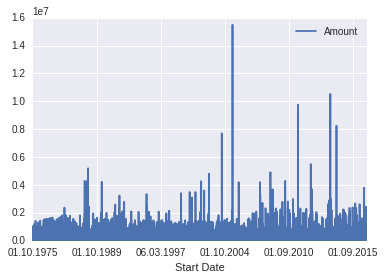

In [12]:
data[~data['Start Date'].isnull()].plot(x='Start Date',y='Amount')

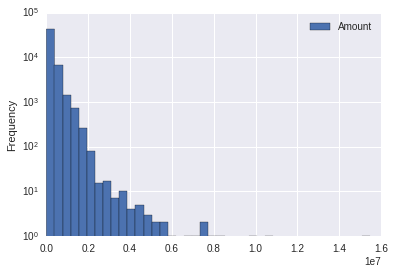

In [13]:
data.plot(x='Start Date',y='Amount',kind='hist',logy=True,bins=40)
df = data

The distribution of the dataset does not seem to follow a power law, since the general behaviour is non linear, or it could be only for law values of grants, because of a heavy tail at high values. 

# Outliers identification

We want now to identify the outlier points in the grants amount distribution. Our hypothesis concerning the outliers of the distribution is that the more granted the project, the longer it takes to be carried out. We add a column to the dataset to specify the duration of the project, using the datetime format.

In [14]:
dates = []
for date in data[['Start Date','End Date']].itertuples(index=False):
    dates.append(pd.to_datetime(date[1])-pd.to_datetime(date[0]))

In [15]:
data['Duration'] = dates
data.head()

,Institution,University,Amount,Start Date,End Date,Duration
Project,,,,,,
1,NaN,Nicht zuteilbar - NA,11619.0,01.10.1975,30.09.1976,629 days
4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.0,01.10.1975,30.09.1976,629 days
5,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0,01.03.1976,28.02.1985,3344 days
6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.0,01.10.1975,30.09.1976,629 days
7,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.0,01.01.1976,30.04.1978,850 days


We convert days into int in order to be able to draw plots.

In [16]:
duration = []
for dur in data.Duration:
    if(pd.isnull(dur)):
        duration.append('NaN')
    else:
        duration.append(dur.days)

In [17]:
data['Duration']=duration
data.Duration = data.Duration.astype(float)
data.head()

,Institution,University,Amount,Start Date,End Date,Duration
Project,,,,,,
1,NaN,Nicht zuteilbar - NA,11619.0,01.10.1975,30.09.1976,629.0
4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.0,01.10.1975,30.09.1976,629.0
5,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0,01.03.1976,28.02.1985,3344.0
6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.0,01.10.1975,30.09.1976,629.0
7,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.0,01.01.1976,30.04.1978,850.0


We make a scatter plot in log-log scale to visually see the correlation between the number of days has lasted a project, and the grant received. 

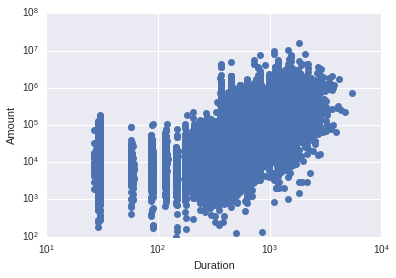

In [18]:
plt.loglog(data['Duration'], data['Amount'],'o')
plt.xlabel('Duration')
plt.ylabel('Amount')

Our hypothesis seems to be confirmed. Grants and duration are positively correlated, so that highly granted projects do not represent "bad" outliers, but are linked to longer projects.

# From university to canton

In order to be able to visually see the repartition of the grants by canton using Folium, we need to find a way to map each Swiss university to its corresponding canton. To do so, we will use geonames, making a request for each new entry, and extracting the canton from the output we get. 
First, we only keep the three columns of interest in our dataframe: 'Institution', 'University' and 'Amount'; and we check if the type of each column is the one we want.

In [19]:
df = df[['Institution', 'University', 'Amount']]
print(df.shape)
print(df.dtypes)

(52237, 3)
Institution     object
University      object
Amount         float64
dtype: object


In [20]:
df.head()

,Institution,University,Amount
Project,,,
1,NaN,Nicht zuteilbar - NA,11619.0
4,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,41022.0
5,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0
6,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,52627.0
7,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.0


In [21]:
df = df.reset_index()

Now, we get the url from which we will make requests on geonames. 

In [22]:
username = 'deatinor'
url = 'http://api.geonames.org/postalCodeSearchJSON?'

correspondencies_dictionary is the dictionary that, for each University/Institution, gives the corresponding canton. We first set the entries that geonames is not able to give (or the main ones that are wrong when we ask geonames). This set has been obviously added after a first try, by extracting the results that have not been given and by checking the most important ones that we can map by hand to have enough accuracy on our results.

In [23]:
correspondencies_dictionary = {'CERN':'GE','Projekte + Ausbildung Soziales Gesundheit Rehabilitation':'ZH',
                              'Psychotherapeutische Abteilung Universitäre Psychiatrische Kliniken UPK':'BS',
                              'Pädagogische Hochschule Fachhochschule Nordwestschweiz, Pädagogische Hochschule Nordwestschweiz - PHFHNW':'BS',
                              'Kalaidos Fachhochschule Departement Gesundheit, Fachhochschule Kalaidos - FHKD':'ZH',
                              'Eawag':'ZH',
                              'Pädagogische Hochschule FHNW, Pädagogische Hochschule Nordwestschweiz - PHFHNW':'BL',
                              'Naturwissenschaftsdidaktik Sekundarstufe Pädagogische Hochschule Fachhochschule Nordwestschweiz, Pädagogische Hochschule Nordwestschweiz - PHFHNW':'BL',
                              'Forschungsgruppe Sozioökonomie Forschungsbereich Agrarökonomie Agroscope':'VD',
                              'Departement Erziehungswissenschaften Universität Freiburg': 'FR',
                              'Eidg. Material und Prüfungsanstalt - EMPA': 'SG',
                              'Fachhochschule Nordwestschweiz (ohne PH) - FHNW': 'SO',
                              'Haute école de santé ARC Haute Ecole Spécialisée de Suisse occidentale':'JU',
                              'HES de Suisse occidentale - HES-SO':'JU',
                              'Haute école de santé ARC Haute Ecole Spécialisée de Suisse occidentale':'JU',
                              'Haute école pédagogique BE, JU, NE - HEPBEJUNE': 'JU',
                              "IHEID Fondation pour l'institut de hautes études internationales et du développement": 'GE',
                              'Idiap Research Institute - IDIAP': 'VS',
                              'Inst. Suisse de Spéléologie et Karstologie - ISSKA': 'JU',
                              'Inst. de Hautes Etudes Internat. et du Dév - IHEID': 'GE',
                              'Institut de physique de la matière condensée EPFL - SB - ICMP': 'VD', 
                              'Laboratoire de Neurologie et Imagerie de la Cognition Dépt. de Neurosciences Fondamentales': 'GE',
                              'Laboratoire de physique de la matière vivante EPFL - SB - IPSB - LPMV': 'VD',
                              'Schweiz. Institut für Kunstwissenschaft - SIK-ISEA': 'ZH',
                              'Station fédérale de recherches agronomiques de Changins': 'VD',
                              'Università della Svizzera italiana - USI': 'TI',
                              }

The reject_list is the list of entries that geonames is not able to find and that we have not been able to find neither, either because they are not universities (ex: NPO field), or because they are not very famous. We thus just decide not to consider them, since we have verified the amount of grants they receive and this is negligible in comparison to the other universities.

In [24]:
reject_list = ['Firmen/Privatwirtschaft - FP',
              'Institut für Physikalische Chemie Universität Freiburg',
              'NPO (Biblioth., Museen, Verwalt.) - NPO',
              'Nicht zuteilbar - NA',
              "UMR 6578 CNRS Unité d'anthropologie Faculté de Médecine Université de la Méditerranée",
              'UNI: Centre de Recherche sur les Maladies Au toimmune Groupe Hospitalier Necker Paris F',
              'UNI: Heriott-Watt University Department of M athematics Riccarton Edinburgh GB',
              'UNI: IMAGE et VILLE Institut de Géographie Strasbourg F',
              'UNI: University of East Anglia Climatic Rese arch Unit  Norwich GB',
              'Weitere Institute - FINST',
              'Weitere Spitäler - ASPIT'
              ]

We keep in memory the number of singular entries that we have manually added or non considered, to be sure that we have considered more than 95% of the universities.

In [25]:
nb_manual = len(correspondencies_dictionary)
nb_reject = len(reject_list)-4 # the 4 corresponds to the nan values, not to 
# the universities we have not found.

We set some parameters for the requests, chosen from the documentation [here](http://www.geonames.org/export/web-services.html#postalCodeSearch).

In [26]:
params = {'username':username,'placename':'CH','maxRows':1,'operator':'OR'}
r = requests.get(url,params=params)

Now, we loop on the rows of the dataframe and make requests recursively in order to complete the correspondencies_dictionary. The code is commented along the loop to make it easily to understand.

In [27]:
# i is an index that allows us to know at which point of the loop we are (see 
# last lines of this cell)
i = 0
# prepare the final data frame that will contain all grants with the name of the
# university, the corresponding canton and the correponding amount of the grant.
df_final = pd.DataFrame({'Name':[],'Canton':[],'Amount':[]})
# not_found_list is here to check if some universities have not been found and matched
# to a canton.
not_found_list = []
# Loop on the rows of the dataframe:
for block in df[['Institution','University','Amount']].itertuples(index=False):
    nan1 = str(block[0]) #institution field of the actual row
    nan2 = str(block[1]) #university field
    amount = block[2] #amount field
    
    # By default, the query will be made using both the university and the institution
    # field, separated by a comma. If the university field is nan, we look at the 
    # institution field only, and inversely. 
    if nan1 == 'nan':
        if nan2 == 'nan':
            raise('Bad preprocessing - double nan')
        query_string = block[1]
    elif nan2 == 'nan':
        query_string = block[0]
    else:
        query_string = block[0] + ", " + block[1]
    
    # List of checks if the string is already present in the dictionary (see comments 
    # above):
    # 1- institution + university 
    # 2- university 
    # 3- query to geonames
    try:
        # if the query_string is in the reject_list, we do not consider it since we know
        # (after a first round) that it cannot been found.
        if query_string in reject_list:
            continue
        # if the query_string is already in the dictionary, we already know the
        # corresponding canton, and thus we just fill the final dataframe.
        canton = correspondencies_dictionary[query_string]
        df2 = pd.DataFrame({'Name':[query_string],'Canton':[canton],'Amount':[amount]})
        df_final = df_final.append(df2)
    except:
        # if the query_string is not yet in the dictionary...
        try:
            # ... if just the university field is already in the reject_list or in
            # the dictionary, we do the same as before.
            query_string_university = str(block[1])
            if query_string_university in reject_list:
                #print(query_string)
                continue
            canton = correspondencies_dictionary[query_string_university]
            df2 = pd.DataFrame({'Name':[query_string_university],'Canton':[canton],'Amount':[amount]})
            df_final = df_final.append(df2)
        except:
            # if nor the query_string nor the university field is already in the 
            # dictionary, we make a request on geonames with the query_string as the
            # 'placename'. 
            try:
                # call geonames with the query_string
                params['placename'] = query_string
                r = requests.get(url, params=params)
                df1 = pd.read_json(r.text, orient='records')
                canton = df1.postalCodes[0]
                
                # if the university field is not empty, also call geonames but only with 
                # it (the university field). The answer is a dataframe of a unique
                # element which is a dictionary. We consider only the dictionary. Then,
                # If the answer we get with geonames is the same in both cases, we 
                # only consider the university field as the query_string, from now on.
                if nan2!='nan':
                    query_string_short = block[1]
                    r = requests.get(url, params=params)
                    df1 = pd.read_json(r.text, orient='records')
                    canton2 = df1.postalCodes[0]
                    if canton2 == canton:
                        query_string = query_string_short
                    else:
                        print(canton2,canton)
                
                # check that the country code is Switzerland. If not, we ignore. Otherwise,
                # we complete the dictionnary with the canton found.
                if canton['countryCode'] != 'CH':
                    continue
                df2 = pd.DataFrame({'Name':[query_string],'Canton':[canton['adminCode1']],'Amount':[amount]})
                df2 = df2.rename(columns={'adminCode1':'Canton'})
                df_final = df_final.append(df2)
                correspondencies_dictionary[query_string] = df2.Canton[0]
            except:
                # in any other case, we append the not_found_list, since we have not found
                # any mapping canton for the considered university. 
                print(query_string)
                not_found_list.append(query_string)
                
    # Inform us at which point of the research we are.
    i += 1
    if i%5000 == 0:
        print(i)

5000
10000
15000
20000
25000
30000
35000
40000
45000


We see that there is no other entry than the ones in the reject_list and the ones handwritten at the beginning, that have not been found. 

In [28]:
total_len = len(df_final.Name.value_counts()) + nb_reject
total_reject = nb_manual + nb_reject
considered = (total_len-total_reject)/total_len*100
considered

94.585448392555

In [29]:
df_final.shape

(46129, 3)

In [30]:
len(correspondencies_dictionary)

584

We have managed to consider around **95%** of the universities, which is enough for the requirements of our study. We thus have 584 universities considered and mapped to cantons, corresponding to 46129 grants, as showed below:

In [31]:
correspondencies_dictionary

{'Abt. Industriegüter- & Technologiemarketing Inst. für Marketing und Unternehmensführung Universität Bern': 'BE',
 'Abteilung Biochemie Biozentrum Universität Basel': 'BS',
 'Abteilung Gastroenterologie Departement Klinische Forschung Universität Bern': 'BE',
 'Abteilung Molekulare Pathobiologie Vetsuisse-Fakultät Universität Bern': 'BE',
 'Abteilung Pharmakologie/Neurobiologie Biozentrum der Universität Basel': 'BS',
 'Abteilung Populationsgenetik Institut für Ökologie und Evolution Universität Bern': 'BE',
 'Abteilung c2d Zentrum für Demokratie Aarau Universität Zürich': 'ZH',
 'Anatomisches Institut Universität Zürich': 'ZH',
 'Anthropologisches Institut und Museum Universität Zürich-Irchel': 'ZH',
 'Architektur und Bauprozess Institut für Technologie in der Architektur ETH Zürich': 'ZH',
 'Archivio di Stato del Canton Ticino': 'TI',
 'Berner Fachhochschule - BFH': 'BE',
 'Biotechnologie Institut Thurgau - BITG': 'TG',
 'Biozentrum der Universität Basel Systembiologie': 'BS',
 'Bot

We finally ordinate the correspondencies_dictionary into a dataframe.

In [32]:
df_final['index'] = range(df_final.shape[0])
df_final = df_final.set_index(['index'])
df_final.head()

,Amount,Canton,Name
index,,,
0,41022.0,GE,Université de Genève - GE
1,52627.0,BS,Universität Basel - BS
2,53009.0,FR,Université de Fribourg - FR
3,25403.0,FR,Université de Fribourg - FR
4,47100.0,ZH,Universität Zürich - ZH


# Folium visualization
Now that we have managed to map the universities to their corresponding cantons, we can prepare the visualization, and then use Folium. To do so, we first group the grants by canton.

In [33]:
a = df.groupby(df_final.Canton)

We prepare the dataframe containing each canton and the corresponding total grants they have received.

In [34]:
df_group = pd.DataFrame({'Canton':[],'Amount':[]})

Now, we list all the Swiss cantons and by looping on the dataframe df_group, we sum the grants amount received by each canton. Note that not all the cantons have received grants (6 have not received anything out of 26), so that this list of all the cantons has to be done to be sure not to miss any.

In [35]:
for i,group in a:
    s = group['Amount'].sum()
    df_group = df_group.append(pd.DataFrame({'Canton':[i],'Amount':[s]}))

In [36]:
canton_list=['ZH','BE','LU','UR','SZ','OW','NW','GL','ZG','FR','SO','BS','BL','SH','AR','AI','SG','GR','AG','TG','TI','VD','VS','NE','GE','JU']

In [37]:
for i in canton_list:
    isin = df_group.Canton.isin([i]).sum()
    if not isin:
        df_group = df_group.append(pd.DataFrame({'Canton':[i],'Amount':[0]}))

Here is presented how much money each canton has received:

In [38]:
df_group

,Amount,Canton
0,1.014063e+08,AG
0,1.379930e+09,BE
0,9.932690e+05,BL
0,1.123703e+09,BS
0,4.859806e+08,FR
0,1.492375e+09,GE
0,1.606712e+07,GR
0,7.332745e+07,JU
0,1.153888e+08,LU
0,3.698074e+08,NE


It only remains to create the folium map thanks to the topojson. The threshold_scale allows us to determine the color difference. It has been chosen to be able to visualize better the difference between cantons. The color present the amount of grants (high amount = dark color; low amount = light color) on each canton, separately.

In [39]:
map_osm = folium.Map(location=[47, 7])
state_geo = r'ch-cantons.topojson.json'
map_osm.choropleth(geo_path=state_geo,key_on='feature.id',topojson='objects.cantons',data=df_group,
                   columns=['Canton','Amount'],fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
                  legend_name='Total grants per canton',
                  threshold_scale=[1e05, 1e06, 1e07, 1e08, 1e09,2e09],)
map_osm.save('map.html')

The map is saved in the html file called map.html To visualize it, download the html file and open it in a browser. We also save the grouped data set in a csv file to avoid to compute everything again each time.

In [57]:
df_group.to_csv('group_canton.csv')

# Bonus: Estimate of the Röstigraben effect

Determine the Röstigraben virtual line and apply it to the dataset:

In [78]:
french = ['GE','VD','FR','JU','NE','VS']
rostigraben = []
for canton in df_group.Canton:
    if canton in french:
        rostigraben.append('fr')
    else:
        rostigraben.append('de')

In [79]:
database = pd.DataFrame({'Canton' : df_group.Canton, 'Grants' : df_group.Amount, 'Rostigraben' : rostigraben})
database = database.reset_index()
database = database.drop('index',axis=1)
database

,Canton,Grants,Rostigraben
0,AG,1.014063e+08,de
1,BE,1.379930e+09,de
2,BL,9.932690e+05,de
3,BS,1.123703e+09,de
4,FR,4.859806e+08,fr
5,GE,1.492375e+09,fr
6,GR,1.606712e+07,de
7,JU,7.332745e+07,fr
8,LU,1.153888e+08,de
9,NE,3.698074e+08,fr


Rough estimate of the Röstigraben separation:

In [80]:
grouped = database.groupby('Rostigraben')
# group and normalize by the number of Cantons in each group
SUM = grouped.sum()
SUM.loc['de'] = SUM.loc['de']/10.0
SUM.loc['fr'] = SUM.loc['fr']/6.0
SUM

,Grants
Rostigraben,
de,6.376253e+08
fr,7.485102e+08


Let us determine the quantitative difference between the two populations.
Since the grants distribution is spread throughout several orders of magnitude, we perform our analysis on its base-10 logarithm. We will then look out the following variables:

In [82]:
display(Math(r'X = \log_{10}(Grants_{FR}), \:\:Y = \log_{10}(Grants_{DE})'))

<IPython.core.display.Math object>

We observe the sample distribution through two boxplots; in the first the global behaviour of the grants is shown, without distinguishing between French and German Cantons. In the second one, instead, we identify the two populations and take a look at the difference in the distributions.

We decide to ignore the cantons that do not receive any grant, since they are all from the German part of the Röstigraben, and since we are expecting the German part to receive more money. Indeed, since we want to compare the means between the German and the French part, not considering them will just diminuish the effect. But if the test without the deleted cantons is rejected, it would also be rejected with those cantons.

In [83]:
database = database[database.Grants != 0]

In [84]:
# identify the two populations
x = database[database.Rostigraben == 'de'].Grants
y = database[database.Rostigraben == 'fr'].Grants

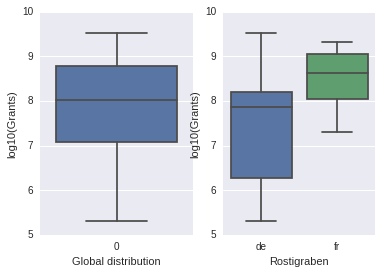

In [85]:
# global boxplot in logarithmic scale
plt.subplot(1,2,1)
ax = sns.boxplot(data=database.Grants.apply(np.log10))
ax.set(xlabel='Global distribution', ylabel='log10(Grants)')
plt.subplot(1,2,2)
ax1 = sns.boxplot(y=database.Grants.apply(np.log10), x = database.Rostigraben)
ax1.set(xlabel='Rostigraben', ylabel='log10(Grants)')

The two identified populations seem to have a qualitatively different distribution: the French-speaking Cantons show a higher mean and a lower variance with respect to the German-speaking one. Moreover, the two populations have a quite symmetric behaviour; for the sake of a rough estimate, we assume that these populations are normally distributed, with different mean and variance. Since we are looking at the base-10 logarithms of the grants amount, we are actually claiming that:

In [86]:
display(Math(r'X \sim \mu_1+\epsilon_1, \:\epsilon_1 \sim \mathcal{N}(0,\sigma_1^2), \: Grants_{FR} = 10^{X}'))
display(Math(r'Y \sim \mu_2+\epsilon_2, \:\epsilon_2 \sim \mathcal{N}(0,\sigma_2^2), \: Grants_{DE} = 10^{Y}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Supposing that X and Y are normally distributed is equivalent to state that the variables 10^X and 10^Y have a lognormal distribution (see https://en.wikipedia.org/wiki/Log-normal_distribution). Since the two samples have different dimension, mean and variance, we are actually performing a non-standard version of the T-test, which is called Welch's t-test (see https://en.wikipedia.org/wiki/Welch%27s_t-test). It works exactly as the T-test but for a different estimate of the degrees of freedom of the resulting T distribution. We report the statistic and the p-value of the test.

In [87]:
test = stat.ttest_ind(y.apply(np.log10),x.apply(np.log10),axis=0,equal_var=False)
test = [test.statistic,test.pvalue]
print("Welch's test for means of two populations with different variance")
print('Test statistic: '+str(test[0]))
print('Test p-value: '+str(test[1]))

Welch's test for means of two populations with different variance
Test statistic: 2.08277838084
Test p-value: 0.0537838938752


Since the p-value of the test is around 5%, we conclude that there is no strong statistical evidence to claim that the Röstigraben separates two cultural areas with different access to financial resources for academic projects, even if it is close to be so.